# Run the x-match using the GC method

The "great-circle" x-matching method was implemented on `booq`, now we have tested and fixed the errors we should run on a small sample of real data (cs82 and vla)

In [1]:
import booq

In [2]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 5.0) 

In [3]:
from booq.io import fits

cs82 = fits.open('data/cs82_luckSquare.fits')
svla = fits.open('data/vla_luckSquare.fits')

colsA = {'ra':'ALPHA_J2000','dec':'DELTA_J2000','id':'SE_ID'}
catA = cs82.read( columns=colsA.values())

colsB = {'ra':'RA','dec':'DEC','id':'Str82'}
catB = svla.read(columns=colsB.values())

from booq.table import ATable
A = ATable(catA.data).to_pandas()
B = ATable(catB.data).to_pandas()

In [4]:
A.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528137 entries, 0 to 528136
Data columns (total 3 columns):
SE_ID          528137 non-null int32
ALPHA_J2000    528137 non-null float64
DELTA_J2000    528137 non-null float64
dtypes: float64(2), int32(1)
memory usage: 10.1 MB


In [5]:
B.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 3 columns):
RA       879 non-null float64
DEC      879 non-null float64
Str82    879 non-null object
dtypes: float64(2), object(1)
memory usage: 20.7+ KB


In [6]:
from booq.coordinates.skycoords import skycoords
A_coord = skycoords(A.ALPHA_J2000.values, A.DELTA_J2000.values)
B_coord = skycoords(B.RA.values, B.DEC.values)

length : 529016
min : 0.0150427097942
max : 1049.70394273
mean : 197.894605307
std : 149.923869294
quantiles : (99.642187302709303, 161.29729778795013, 243.39168509551419)


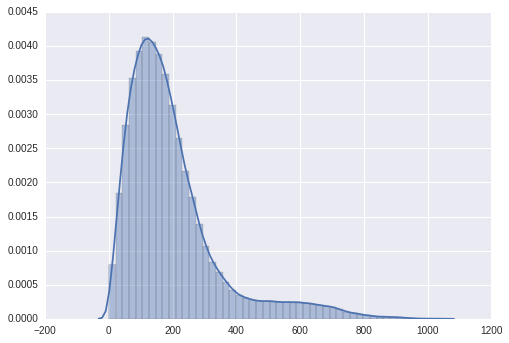

In [7]:
from booq.catalogs import xmatch
_Aidx,_Asep = xmatch.nn(A_coord,B_coord)
_Bidx,_Bsep = xmatch.nn(B_coord,A_coord)

import numpy
_sep = numpy.append(_Asep.arcsec,_Bsep.arcsec)

from booq.utils import stats
_sts = stats.basic(_sep)

from booq import utils
utils.pprint(_sts)

import seaborn
p = seaborn.distplot(_sep)
plt.show(p)

del _Aidx,_Asep,_Bidx,_Bsep,_sts,_sep

In [8]:
from astropy.units import Quantity
radius = Quantity(2,'arcsec')

In [9]:
from booq.catalogs import xmatch
match_A_gc_idx, match_B_gc_idx, match_gc_sep = xmatch.gc(A_coord, B_coord, radius)

In [10]:
from booq import utils
utils.pprint(utils.stats.basic(match_gc_sep.arcmin))

length : 401
min : 0.000250711829904
max : 0.0333253957801
mean : 0.00935545145988
std : 0.00920822610898
quantiles : (0.0029152712569407808, 0.005501477874166787, 0.012965165870444608)


In [11]:
from booq.pipelines import xmatch_nn
reload(xmatch_nn)
df_matched_idx = xmatch_nn.select_pairs(match_A_gc_idx, match_B_gc_idx, match_gc_sep.arcmin)
df_matched_idx.describe(include='all')

,A_idx,B_duplicates,B_idx,separation
count,395.000000,6,395.000000,395.000000
unique,NaN,6,NaN,NaN
top,NaN,401,NaN,NaN
freq,NaN,1,NaN,NaN
mean,301284.564557,NaN,422.653165,0.009053
std,151902.361069,NaN,237.207332,0.008949
min,2085.000000,NaN,50.000000,0.000251
25%,160266.000000,NaN,218.000000,0.002868
50%,334993.000000,NaN,409.000000,0.005408
75%,425480.000000,NaN,600.500000,0.011394


In [12]:
from booq.pipelines import xmatch_nn
reload(xmatch_nn)
df = matched_catalog = xmatch_nn.merge_catalogs(A, B, df_matched_idx, 'Str82')

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [13]:
df.describe(include='all')

/home/chbrandt/.conda/envs/booq-dev/lib/python2.7/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


A                                         B              \
                SE_ID    ALPHA_J2000    DELTA_J2000          RA         DEC   
count   528137.000000  528137.000000  528137.000000  395.000000  395.000000   
unique            NaN            NaN            NaN         NaN         NaN   
top               NaN            NaN            NaN         NaN         NaN   
freq              NaN            NaN            NaN         NaN         NaN   
mean     67316.181656      13.021675       0.040702   13.128274    0.138412   
std      36346.045266       0.836532       0.563889    0.699448    0.526262   
min       1372.000000      11.594873      -0.999989   11.787167   -0.998853   
25%      36981.000000      12.232602      -0.464393         NaN         NaN   
50%      66892.000000      13.098465       0.111200         NaN         NaN   
75%      96582.000000      13.742887       0.528693         NaN         NaN   
max     150430.000000      14.405139       0.940626   14.232887    0.909142   

                                  AB                    
                   Str82        dist      B_duplicates  
count                395  395.000000                 6  
unique               360         NaN                 6  
top     J005444.9-002752         NaN  J005200.1-004831  
freq                   3         NaN                 1  
mean                 NaN    0.009053               NaN  
std                  NaN    0.008949               NaN  
min                  NaN    0.000251               NaN  
25%                  NaN         NaN               NaN  
50%                  NaN         NaN               NaN  
75%                  NaN         NaN               NaN  
max                  NaN    0.033311               NaN

## Now, the pipeline

In [14]:
import booq
logging = booq.log.init(verbose=True,debug=True)

from booq.io import fits

cs82 = fits.open('data/cs82_luckSquare.fits')
svla = fits.open('data/vla_luckSquare.fits')

colsA = {'ra':'ALPHA_J2000','dec':'DELTA_J2000','id':'SE_ID'}
catA = cs82.read( columns=colsA.values())

colsB = {'ra':'RA','dec':'DEC','id':'Str82'}
catB = svla.read(columns=colsB.values())

from booq.table import ATable
A = ATable(catA.data).to_pandas()
B = ATable(catB.data).to_pandas()

In [15]:
from booq.pipelines import xmatch_nn
matched_catalog = xmatch_nn.xmatch(A,B,columns_A=colsA, columns_B=colsB, radius=2, method='gc')

In [16]:
matched_catalog.describe(include='all')

A                                         B              \
                SE_ID    ALPHA_J2000    DELTA_J2000          RA         DEC   
count   528137.000000  528137.000000  528137.000000  395.000000  395.000000   
unique            NaN            NaN            NaN         NaN         NaN   
top               NaN            NaN            NaN         NaN         NaN   
freq              NaN            NaN            NaN         NaN         NaN   
mean     67316.181656      13.021675       0.040702   13.128274    0.138412   
std      36346.045266       0.836532       0.563889    0.699448    0.526262   
min       1372.000000      11.594873      -0.999989   11.787167   -0.998853   
25%      36981.000000      12.232602      -0.464393         NaN         NaN   
50%      66892.000000      13.098465       0.111200         NaN         NaN   
75%      96582.000000      13.742887       0.528693         NaN         NaN   
max     150430.000000      14.405139       0.940626   14.232887    0.909142   

                                  AB                    
                   Str82        dist      B_duplicates  
count                395  395.000000                 6  
unique               360         NaN                 6  
top     J005444.9-002752         NaN  J005200.1-004831  
freq                   3         NaN                 1  
mean                 NaN    0.543193               NaN  
std                  NaN    0.536912               NaN  
min                  NaN    0.015043               NaN  
25%                  NaN         NaN               NaN  
50%                  NaN         NaN               NaN  
75%                  NaN         NaN               NaN  
max                  NaN    1.998689               NaN